In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from tqdm.auto import tqdm
import os 
from prompt_manager import build_prompt

model_name = 'Llama3.2_1B'
layer_count = 16

def prompt_to_folder_prefix(p):
    if p == '':
        return p
    else:
        return p + '_'

def parse_prompt(p):
    if p == '':
        p = 'joy_sadness_0'

    if '_' in p:
        shots = p.split('_')[:-1]
        prompt_index = int(p.split('_')[-1])
    else:
        shots = []
        prompt_index = int(p)

    func = build_prompt(shots=shots, prompt_index=prompt_index)
    formal_name = f'Template {prompt_index + 1}'
    
    if len(shots) == 1:
        #  formal_name += f'\n Samples: {", ".join(shots)}'
         formal_name += f', 1-shot'

    elif len(shots) > 1:
        # formal_name += f'\n Samples: {", ".join(shots)}'
        formal_name += f', {len(shots)}-shots'
    else:
        formal_name += f'\n No Samples'
    prompt_template = f'{func(r"{__PLACEHOLDER__}")}'
    return formal_name, prompt_template


prompts = [
           'joy_sadness_1',
           'joy_sadness_2',
           'joy_sadness_3',
           'anger_0',
           'anger_boredom_disgust_0',
           'anger_boredom_disgust_fear_guilt_joy_0',
           'anger_boredom_disgust_fear_guilt_joy_neutral_pride_relief_0',
           'anger_boredom_disgust_fear_guilt_joy_neutral_pride_relief_sadness_shame_surprise_0',        
           ]

prompts_formal_names = [f'{parse_prompt(p)[0]}' for i, p in enumerate(prompts)]

prompt_templates = [f'Prompt {i+1}: {parse_prompt(p)[1]}'  for i, p in enumerate(prompts)]

prompts_to_id = {prompts[i]:i for i in range(len(prompts))}
id_to_prompt =  {i:prompts[i] for i in range(len(prompts))}

probe_location_to_formal_name = {3: 'Attention Output', 6: 'MLP Output', 7: 'Hidden State'}
# sort the models based on the layer counts
os.makedirs(f'figs/prompts/', exist_ok=True)
FONT_SIZE = 16



In [180]:

emotion_appraisal_labels = torch.load(f'outputs/{prompt_to_folder_prefix("")}{model_name}/emotion_appraisal_labels.pt', weights_only=False)

emotion_to_id = emotion_appraisal_labels['emotion_to_id']
id_to_emotion = {v: k for k, v in emotion_to_id.items()}

appraisals_to_id = emotion_appraisal_labels['appraisals_to_id']
id_to_appraisals = {v: k for k, v in appraisals_to_id.items()}
appraisal_to_formal_name = {'other_responsblt': 'others\nagency', 'predict_event': 'predictability', 'chance_control':'situational\ncontrol'}

for app in appraisals_to_id.keys():
    if app not in appraisal_to_formal_name:
        appraisal_to_formal_name[app] = app.replace('_', '\n')

appraisals = list(appraisals_to_id.keys())
coefficients = emotion_appraisal_labels['weights']

print("Emotions to study:", emotion_to_id)
print("Appraisals to study:", appraisals_to_id)
print('Appraisal Formal Names:', appraisal_to_formal_name)


Emotions to study: {'anger': 0, 'boredom': 1, 'disgust': 2, 'fear': 3, 'guilt': 4, 'joy': 5, 'neutral': 6, 'pride': 7, 'relief': 8, 'sadness': 9, 'shame': 10, 'surprise': 11, 'trust': 12}
Appraisals to study: {'predict_event': 0, 'pleasantness': 1, 'other_responsblt': 2, 'chance_control': 3, 'suddenness': 4, 'familiarity': 5, 'unpleasantness': 6, 'goal_relevance': 7, 'self_responsblt': 8, 'predict_conseq': 9, 'goal_support': 10, 'urgency': 11, 'self_control': 12, 'other_control': 13, 'accept_conseq': 14, 'standards': 15, 'social_norms': 16, 'attention': 17, 'not_consider': 18, 'effort': 19}
Appraisal Formal Names: {'other_responsblt': 'others\nagency', 'predict_event': 'predictability', 'chance_control': 'situational\ncontrol', 'pleasantness': 'pleasantness', 'suddenness': 'suddenness', 'familiarity': 'familiarity', 'unpleasantness': 'unpleasantness', 'goal_relevance': 'goal\nrelevance', 'self_responsblt': 'self\nresponsblt', 'predict_conseq': 'predict\nconseq', 'goal_support': 'goal\n

In [181]:
emotions_formal = ["joy", "pride", "surprise", "trust",  "relief", "neutral" , "sadness", "boredom", "fear", "guilt", "shame",  "disgust", "anger"]
formal_emotion_to_id = {emotion: i for i, emotion in enumerate(emotions_formal)}
id_to_formal_emotion = {v: k for k, v in formal_emotion_to_id.items()}
assert set(emotions_formal) == set(emotion_to_id.keys())

In [182]:
import pandas as pd
train_data = pd.read_csv('data/enVent_gen_Data.csv', encoding='ISO-8859-1')
raw_texts = train_data['hidden_emo_text'].to_list()

## dataset distribution

In [183]:
values = []
accuracies = []
for prompt in prompts:
    unfiltered_labels, labels = torch.load(f'outputs/{prompt_to_folder_prefix(prompt)}{model_name}/unfiltered_emotion_logits.pt', weights_only=False)
    values.append(unfiltered_labels)
    accuracies.append((unfiltered_labels == labels).float().mean().item())

accuracies = torch.tensor(accuracies)
        
values.insert(0, labels)
values = torch.stack(values, dim=0)

for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        values[i, j] = formal_emotion_to_id[id_to_emotion[values[i, j].item()]]
        
print(values.shape)

frequency = torch.zeros((len(formal_emotion_to_id), values.shape[0]))
for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        frequency[values[i, j].item(), i] += 1


torch.Size([10, 6600])


In [184]:
%load_ext autoreload
%autoreload 2
from plotters_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
print(frequency.shape)

torch.Size([13, 10])


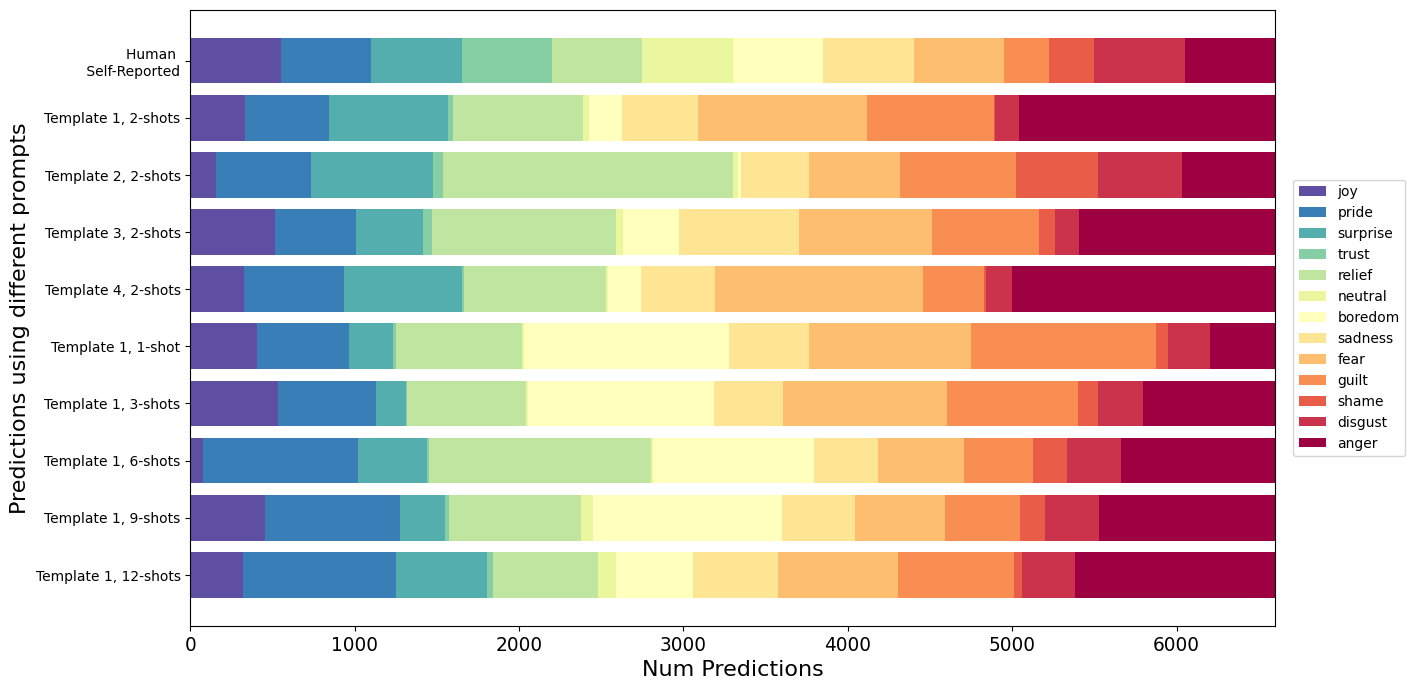

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors



plt.figure(figsize=(14, 8))
bar_width = 0.35
for i in range(frequency.shape[0]):
    val = frequency[:i].sum(dim=0)
    plt.barh(np.arange(frequency.shape[1]), frequency[i], left=val, label=id_to_formal_emotion[i], color=emotion_to_color[id_to_formal_emotion[i]])

plt.yticks(np.arange(frequency.shape[1]), ['Human \n Self-Reported'] + prompts_formal_names)
plt.xlim(0, 6600)
# invert the y axis
plt.gca().invert_yaxis()
plt.xlabel("Num Predictions", fontsize=FONT_SIZE)
plt.ylabel("Predictions using different prompts", fontsize=FONT_SIZE)

plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
# plt.title("Predictions of Emotions by Models")
plt.xticks(fontsize=FONT_SIZE / 1.2)
plt.grid(False)
plt.savefig(f'figs/prompts/prompt_distributions.pdf', bbox_inches='tight', dpi=300)


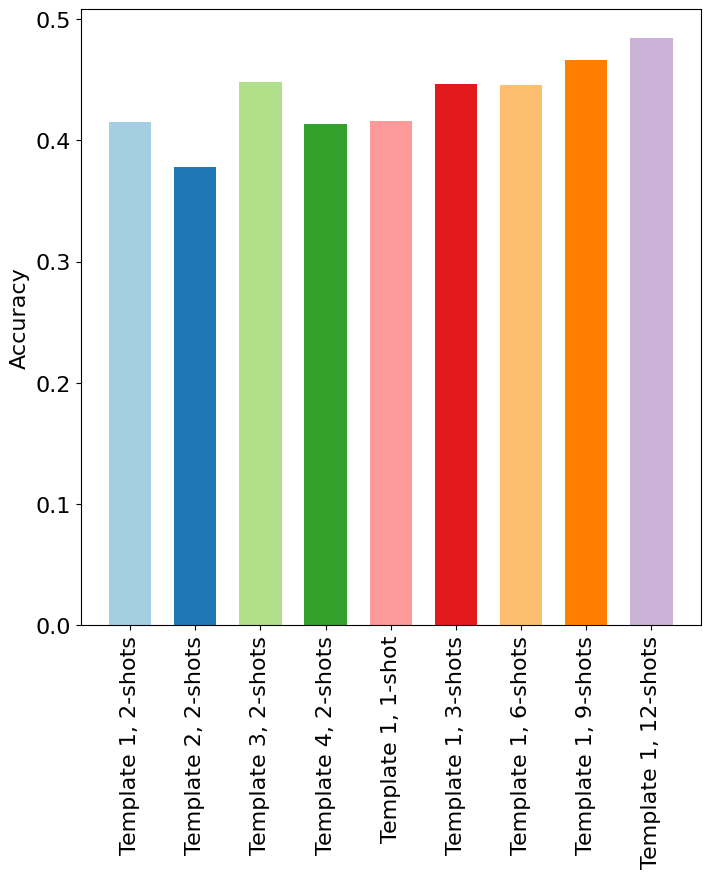

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = sns.color_palette("Paired", len(accuracies))
bar_width = 0.65
# ax.grid(zorder=0)
# ax.xaxis.grid(False)
# ax.yaxis.grid(True)

for i in range(len(accuracies)):
    ax.bar(i, accuracies[i], label=prompts_formal_names[i], color=colors[i], width = bar_width)

xticks = np.arange(len(prompts_formal_names))
ax.set_xticks(xticks, prompts_formal_names, rotation=90)
ax.set_ylabel("Accuracy", fontsize=FONT_SIZE)
ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)

# ax.set_title("Accuracy of Predictions by Models")

# ax.legend(loc='best', bbox_to_anchor=(1.1, 1.1))
plt.savefig(f'figs/prompts/prompt_accs.pdf', bbox_inches='tight', dpi=300)
plt.show()



    

In [189]:
for p in prompt_templates:
    print(p)
    print()

Prompt 1: What are the inferred emotions in the following contexts? Context: My first child was born. Answer: joy Context: My dog died last week. Answer: sadness Context: {__PLACEHOLDER__} Answer:

Prompt 2: Consider this list of emotions: anger, boredom, disgust, fear, guilt, joy, pride, relief, sadness, shame, surprise, trust, neutral. What are the inferred emotions in the following contexts? Context: My first child was born. Answer: joy Context: My dog died last week. Answer: sadness Context: {__PLACEHOLDER__} Answer:

Prompt 3:  Context: My first child was born. Answer: joy Context: My dog died last week. Answer: sadness Context: {__PLACEHOLDER__} Answer:

Prompt 4: Guess the emotion. Context: My first child was born. Answer: joy Context: My dog died last week. Answer: sadness Context: {__PLACEHOLDER__} Answer:

Prompt 5: What are the inferred emotions in the following contexts? Context: My husband missed an important call, because his phone was on silent AGAIN! Answer: anger Conte

## Probing Effect

In [190]:

locs_to_probe = [3, 6, 7]

values = torch.zeros((len(locs_to_probe), len(prompts), layer_count))
layers = list(range(layer_count))
for i, prompt in enumerate(prompts):
    try:
        tokens_ = [-1]
        v = process_emotion_probe_results(f'{prompt_to_folder_prefix(prompt)}{model_name}', layers, locs_to_probe, tokens_)
    except Exception as e:
        tokens_ = list(range(-1, -6, -1))
        v = process_emotion_probe_results(f'{prompt_to_folder_prefix(prompt)}{model_name}', layers, locs_to_probe, tokens_)
    values[:, i] = v[:, tokens_.index(-1)]
    
        


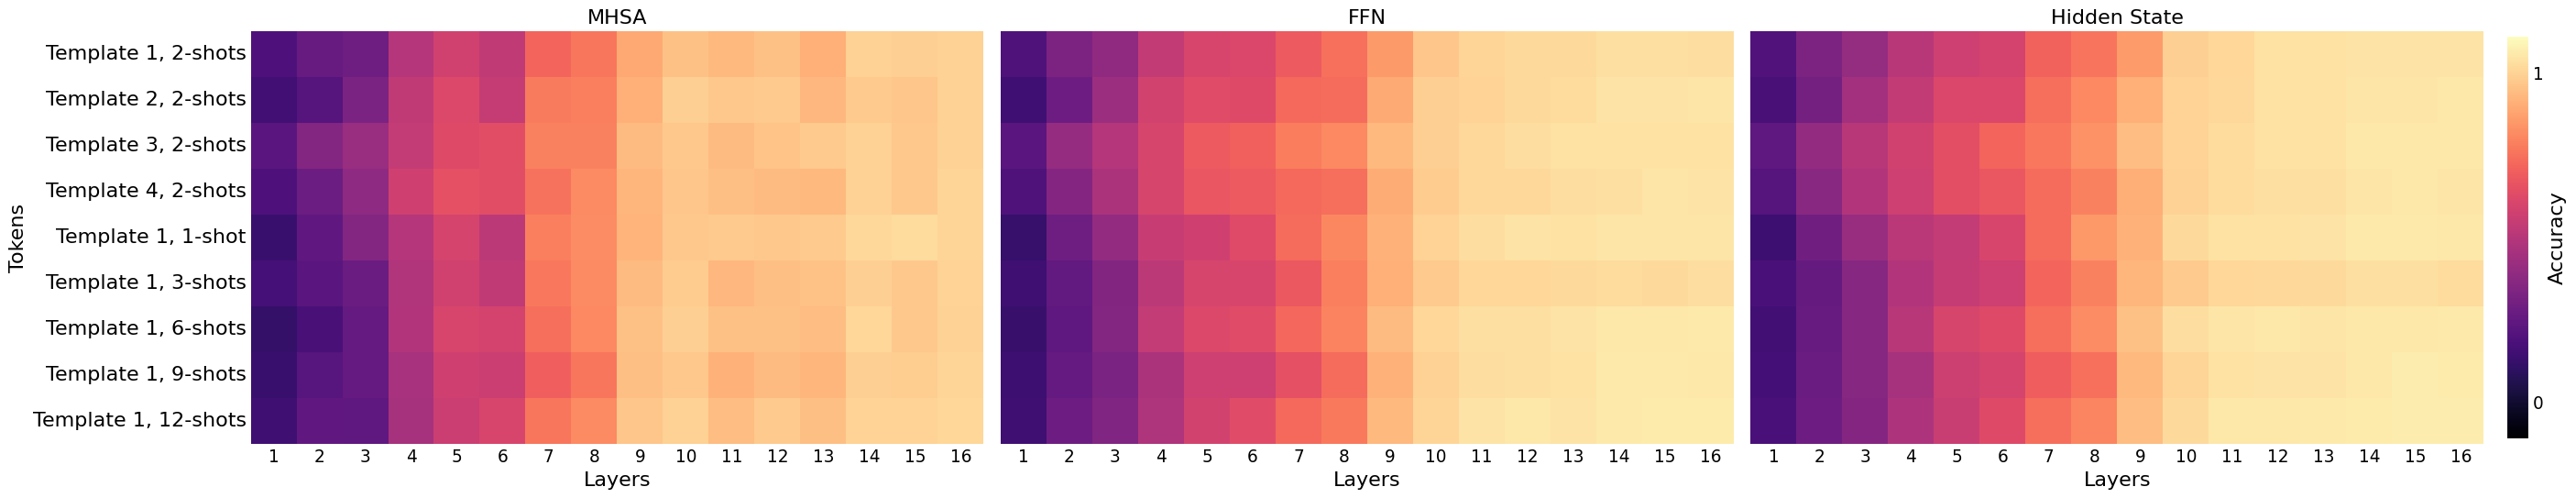

In [195]:


plot_heatmap(values,
             suptitle = f'', titles = [f'{probe_location_to_formal_name[loc]}' for loc in locs_to_probe], fontsize = FONT_SIZE,
             xticks = np.arange(len(layers)) + 0.5, xtick_labels = (torch.tensor(layers) + 1).numpy(),
             yticks = np.arange(len(prompts_formal_names)) + 0.5, ytick_labels = prompts_formal_names,
             yticks_rotation = 0, xticks_rotation = 0,
             vmax=1.0, vmin=0.0,
             x_axis_label='Layers', y_axis_label='Tokens',
             cmap='magma', cmap_label='Accuracy', cmap_shrink=1.0, cmap_aspect=18.0, cmap_fraction=0.01, cmap_pad=0.01,
             cbar_yticks=[0, 0.9], cbar_ytick_labels=[0, 1],
             figsize=(28, 6), save_path = f'prompts/prompt_emotion_probes')

## Zero-Intervention

In [196]:
locs_to_probe = [3, 6, 7]
span = 1
layers_centers = list(range(span // 2, layer_count - span // 2))
tokens = [[-1]]

layers_centers = list(range(span // 2, layer_count - span // 2))
values = torch.zeros((len(locs_to_probe), len(prompts), len(layers_centers)))
for i, prompt in enumerate(prompts):
    tokens = [[-1]]
    v = process_zero_intervention(f'{prompt_to_folder_prefix(prompt)}{model_name}', locs_to_probe, tokens, layers_centers, span)
    values[:, i] = v[:, tokens[0].index(-1)]


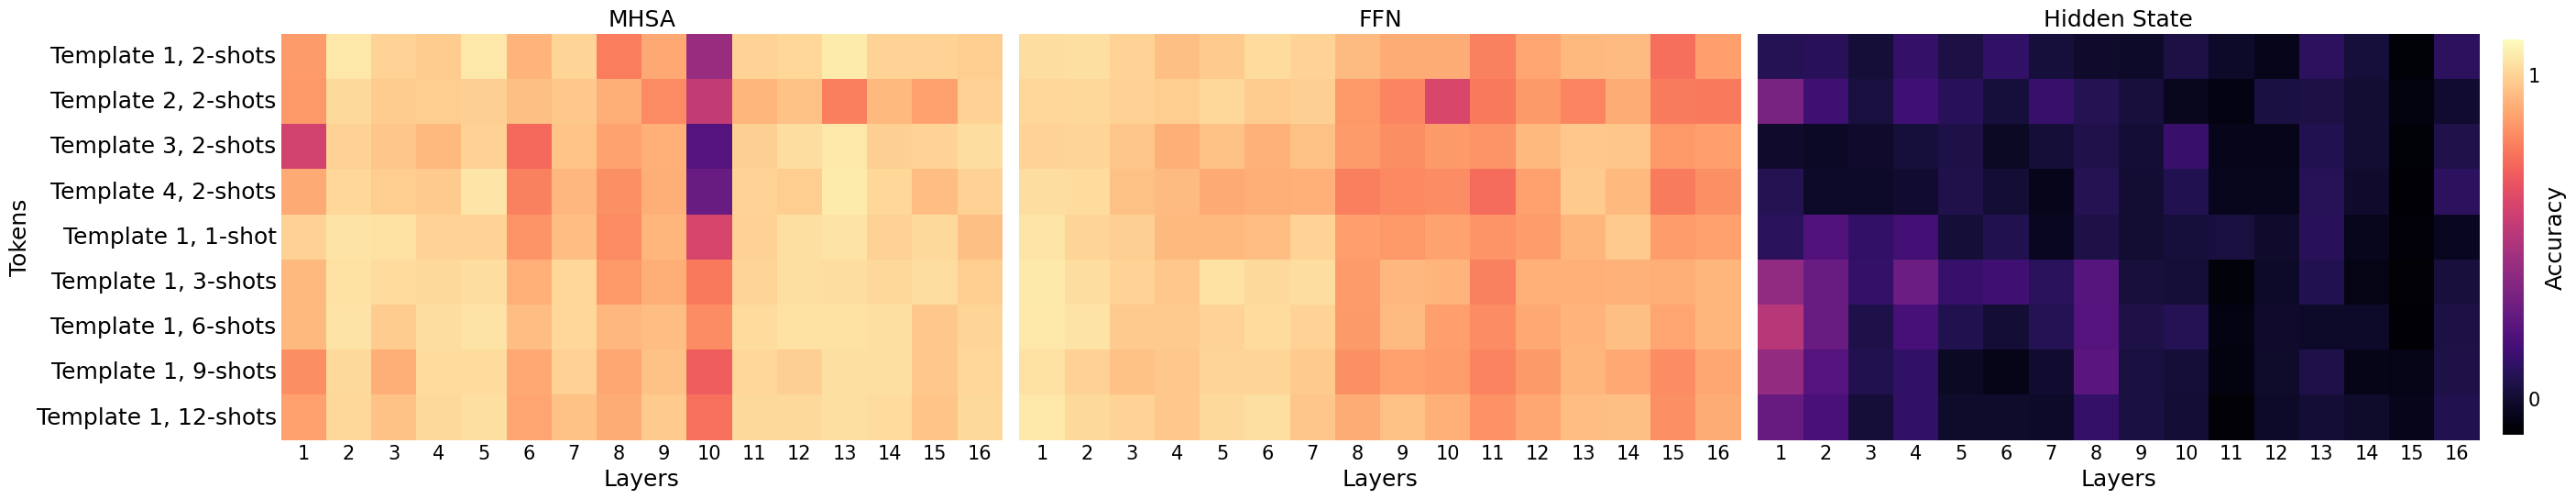

In [176]:
plot_heatmap(values,
             suptitle = f'', titles = [f'{probe_location_to_formal_name[loc]}' for loc in locs_to_probe], fontsize = 18,
             xticks = np.arange(len(layers_centers)) + 0.5, xtick_labels = (torch.tensor(layers_centers) + 1).numpy(),
             yticks = np.arange(len(prompts_formal_names)) + 0.5, ytick_labels = prompts_formal_names,
             yticks_rotation = 0, xticks_rotation = 0,
             vmax=1.0, vmin=0.0,
             x_axis_label='Layers', y_axis_label='Tokens',
             cmap='magma', cmap_label='Accuracy', cmap_shrink=1.0, cmap_aspect=18.0, cmap_fraction=0.01, cmap_pad=0.01,
             cbar_yticks=[0, 0.9], cbar_ytick_labels=[0, 1],
             figsize=(28, 6), save_path = f'')


## Emotion Transfer using Patching

In [197]:

num_exps = 200
span = 3
tokens = [-1]
locs_to_probe = [3, 6, 7]
layers_centers = list(range(span // 2, layer_count - span // 2))
values = torch.zeros((len(locs_to_probe), len(prompts), len(layers_centers)))

for i, prompt in enumerate(prompts):
    v = process_activation_patching(f'{prompt_to_folder_prefix(prompt)}{model_name}', num_exps, locs_to_probe, tokens, layers_centers, span)
    values[:, i] = v[:, tokens.index(-1)][..., 0]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

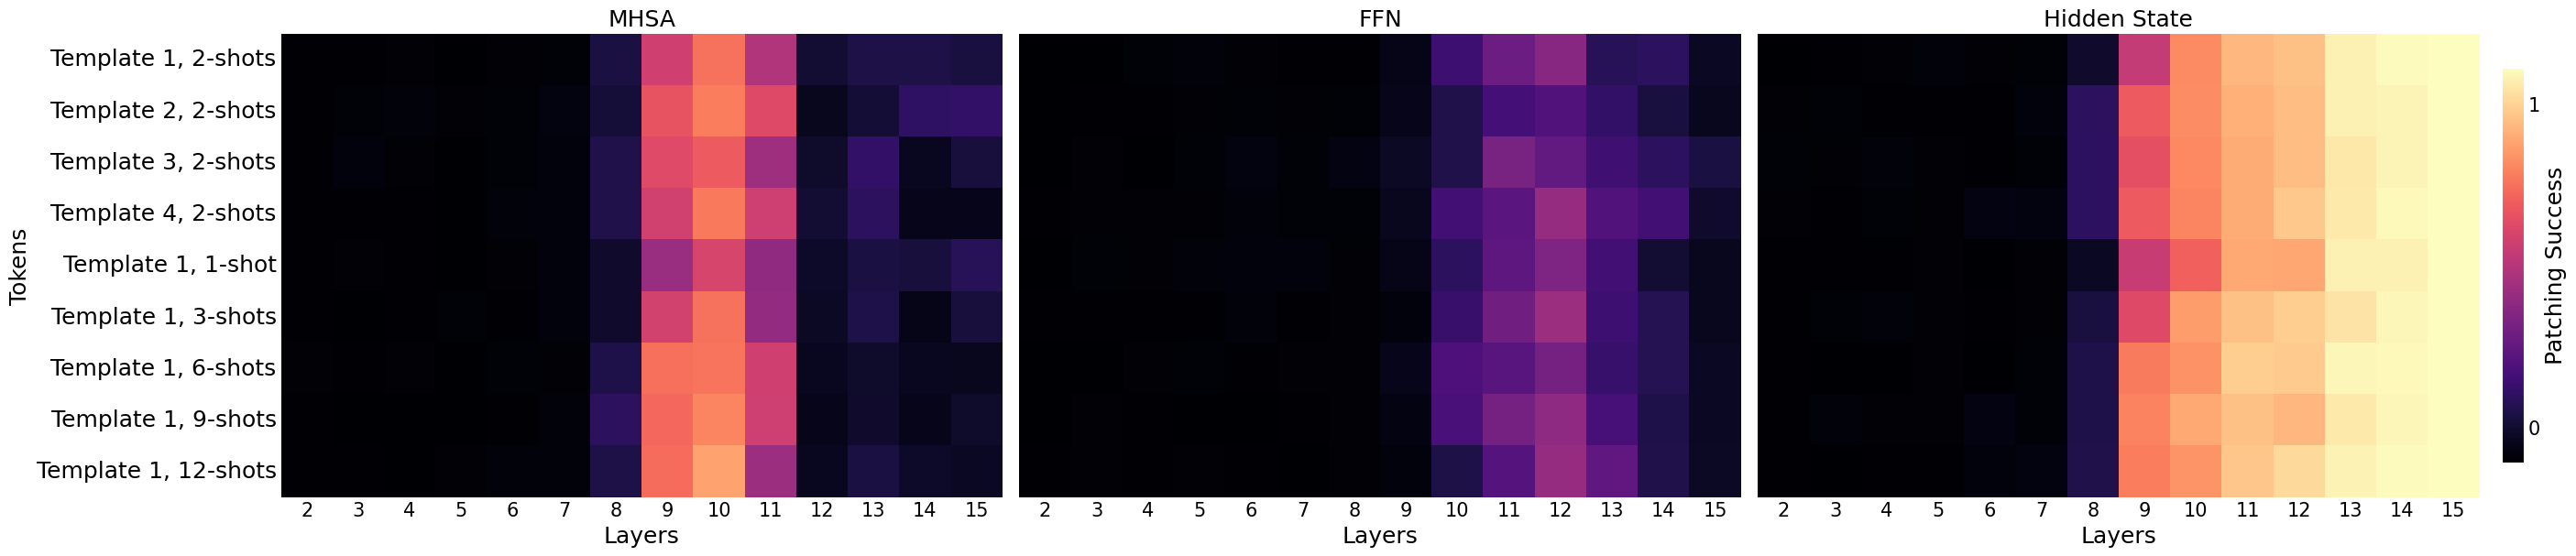

In [199]:
plot_heatmap(values,
             suptitle = f'', titles = [f'{probe_location_to_formal_name[loc]}' for loc in locs_to_probe], fontsize = 18,
             xticks = np.arange(len(layers_centers)) + 0.5, xtick_labels = (torch.tensor(layers_centers) + 1).numpy(),
             yticks = np.arange(len(prompts_formal_names)) + 0.5, ytick_labels = prompts_formal_names,
             yticks_rotation = 0, xticks_rotation = 0,
             vmax=1.0, vmin=0.0,
             x_axis_label='Layers', y_axis_label='Tokens',
             cmap='magma', cmap_label='Patching Success', cmap_shrink=1.0, cmap_aspect=18.0, cmap_fraction=0.01, cmap_pad=0.01,
             cbar_yticks=[0, 0.9], cbar_ytick_labels=[0, 1],
             figsize=(28, 6), save_path = f'prompts/prompt_patching_{span}')


# plot_heatmap(values, layers_centers, prompts_formal_names, locs_to_probe, name = f'patching_span_{span}', title = f'Emotion Transfer Success (with span {span})', subtitle = 'Patching on')